# Importation des librairies et création des dataframes

In [1]:
%pylab inline
import time
import pandas as pd
import sqlite3

from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime, timezone

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create your connection.
cnx = sqlite3.connect('data/movies.sqlite')

movies_df = pd.read_sql_query("SELECT * FROM movies", cnx)
ratings_df = pd.read_sql_query("SELECT * FROM ratings", cnx)

cnx.commit()
cnx.close()

In [3]:
movies_df.head()

,movie_id,title,genre
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,None
4,91,Le manoir du diable (1896),Short|Horror


In [4]:
ratings_df.head()

,user_id,movie_id,rating,rating_timestamp
0,1,114508,8,1381006850
1,2,499549,9,1376753198
2,2,1305591,8,1376742507
3,2,1428538,1,1371307089
4,3,75314,1,1595468524


J'ai choisi d'utiliser pandas pour répondre aux questions du test car c'est l'outil que j'ai le plus utilisé lors de ma formation.

# 1. Dénombrements

## 1.1 Combien de films figurent dans la base de données ?

In [5]:
len(movies_df.movie_id.unique())

38013

In [6]:
len(movies_df)

38018

On peut voir qu'il y a 5 films de plus qu'il y a de films unique. Regardons quel est le problème avec ces films.

In [7]:
movies_df.loc[movies_df.movie_id.duplicated(keep=False)]

,movie_id,title,genre
8456,106519,Carlito's Way (1993),None
8457,106519,Carlito's Way (1993),Crime|Drama|Thriller
18738,1361336,Tom and Jerry (2021),Animation|Adventure|Comedy|Family
18739,1361336,Tom and Jerry (2021),Animation|Adventure|Comedy|Family
22283,1979376,Toy Story 4 (2019),Animation|Adventure|Comedy|Family|Fantasy
22284,1979376,Toy Story 4 (2019),Animation|Adventure|Comedy|Family|Fantasy
29745,4160708,Don't Breathe (2016),Crime|Horror|Thriller
29746,4160708,Don&x27;t Breathe (2016),Crime|Horror|Thriller
36642,9620292,Promising Young Woman (2020),None
36643,9620292,Promising Young Woman (2020),Comedy|Crime|Drama|Thriller


On supprime une entrée au hasard pour les deux films complétement identiques à leur doublon (Tom et Jerry et Toy Story 4)

In [8]:
movies_df = movies_df.drop_duplicates()

Pour les 3 autres films avec des doublons, nous allons supprimer manuellement la moins bonne ligne:
    
    - pour Carlito's Way, il vaut garder la ligne comprenant le genre
    
    - pour Don't Breathe, il vaut mieux garder la ligne qui ne comporte pas de faute
    
    - pour Promising Young Woman il vaut mieux garder la ligne comprenant le genre également.
    
S'il y avait eu plus de 3 films, il aurait fallu trouver une solution systèmatique pour chacun de ces problème, en faire une fonction qui permetterai de choisir la bonne ligne à garder.

In [9]:
movies_df = movies_df.drop([8456, 29746, 36642])

On recompte le nombre de films:

In [10]:
print(len(movies_df.movie_id.unique()))
print(len(movies_df))
nb_movies = len(movies_df)

38013
38013


Nous allons créer une fonction pour entrer les résultats dans le fichier texte.

In [11]:
def writeTitle(string):
    with open("results.txt", "a", encoding="utf8") as f:
        f.write('\n--------------------------------\n')
        f.write(string + '\n')
        f.write('--------------------------------\n')
        
def writeLine(string):
    with open("results.txt", "a", encoding="utf8") as f:
        f.write(string + '\n')

Premièrement, j'éfface ce qu'il y a dans le fichier texte pour pouvoir le réécrire à chaque exécution de ce notebook.

In [12]:
with open("results.txt", "w", encoding="utf8") as f:
        f.write('')

In [13]:
writeTitle("1.1 Combien de films figurent dans la base de données ?")
writeLine(f"{nb_movies} films figurent dans la base de données.")

## 1.2. Combien d'utilisateurs différents figurent dans la base de données ?

Ici, on compte directement le nombre d'id d'utilisateurs uniques.

In [14]:
different_users = len(ratings_df.user_id.unique())
print(different_users)

71707


In [15]:
writeTitle("1.2. Combien d'utilisateurs différents figurent dans la base de données ?")
writeLine(f"{different_users} utilisateurs différents figurent dans la base de données.")

## 1.3. Quelle est la distribution des notes renseignées ?

On compte le nombre de rating avec une note donnée, on en fait un tableau, puis un graph.

In [16]:
ratings_table = ratings_df.value_counts('rating').sort_index()

In [17]:
ratings_table

rating
0        281
1      10814
2       9223
3      15487
4      28193
5      69747
6     120370
7     206680
8     222146
9     130106
10    108351
dtype: int64

<AxesSubplot:title={'center':'Histogramme de la distribution des notes IMDB'}, xlabel='Note', ylabel='Quantité'>

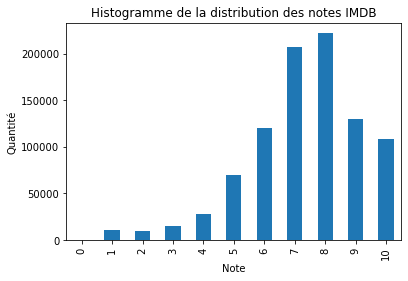

In [18]:
plt.title('Histogramme de la distribution des notes IMDB')
plt.xlabel("Note")
plt.ylabel("Quantité")
ratings_df.rating.value_counts().sort_index().plot(kind = 'bar')

In [19]:
writeTitle("1.3. Quelle est la distribution des notes renseignées ?")
writeLine("Distribution des notes IMDB:\n" + str(ratings_table))

## 1.4. Table des fréquences pour exprimer en pourcentage la répartition des notes

Ici, on créé une nouvelle colonne ou l'on divise le nombre de rating de telle note par le nombre de rating total.

In [20]:
ratings_frequency_table = ratings_df[['rating', 'user_id']].groupby(by="rating").count()

In [21]:
ratings_frequency_table = ratings_frequency_table.rename(columns={'user_id':'frequency'})

In [22]:
ratings_frequency_table['frequency'] = ratings_frequency_table['frequency']/len(ratings_df)

In [23]:
ratings_frequency_table

,frequency
rating,
0,0.000305
1,0.011737
2,0.010010
3,0.016808
4,0.030598
5,0.075697
6,0.130638
7,0.224311
8,0.241097


On vérifie que la somme des fréquences est égale à 1:

In [24]:
ratings_frequency_table.frequency.sum()

1.0

In [25]:
writeTitle("1.4. Table des fréquences pour exprimer en pourcentage la répartition des notes")
writeLine("Tables des fréquences des notes:\n" + str(ratings_frequency_table))

# 2. Sélection et enrichissement des données

## 2.1.

On créé une fonction qui décide si l'utilisateur a aimé le film ou non via le rating.

In [26]:
def isLikedRating(rating):
    if(rating > 6):
        return 1
    else:
        return 0

In [27]:
ratings_df['liked'] = ratings_df.apply(lambda x: isLikedRating(x.rating), axis=1)

In [28]:
ratings_df

,user_id,movie_id,rating,rating_timestamp,liked
0,1,114508,8,1381006850,1
1,2,499549,9,1376753198,1
2,2,1305591,8,1376742507,1
3,2,1428538,1,1371307089,0
4,3,75314,1,1595468524,0
...,...,...,...,...,...
921393,71705,9893250,10,1613857551,1
921394,71705,9898858,3,1585958452,0
921395,71706,172495,10,1587107015,1
921396,71706,414387,10,1587107852,1


In [29]:
writeTitle("2.1. Transformer la note rating en deux modalités : l'utilisateur a-t-il aimé ou pas le film ?")
writeLine("10 premières lignes de la table ratings avec les \"like\"\n" + str(ratings_df.head(10)))

## 2.2

Il y a potentiellement deux questions dans ce 2.2 : "Quels sont les genres les mieux notés par les utilisateurs ?" qui demanderait le rating moyen de chaque genre de film et "Nous souhaitons obtenir le top 10 des genres de films aimés par les utilisateurs" qui nous demanderait de comptabiliser le nombre de "liked" qu'on a créé dans la question précédente. Par continuité de l'exercice, je pense que c'est la deuxième interprétation qui est la bonne mais je souhaite quand même répondre aux deux.

Nous allons tout d'abord créer differentes colonnes dans la table movies pour séparer les genres entre eux.

In [30]:
movies_df.genre.unique()

array(['Documentary|Short', None, 'Short|Horror', ...,
       'Animation|Comedy|Drama|Family|Fantasy|Sci-Fi',
       'Animation|Short|Family|Musical', 'Crime|Documentary'],
      dtype=object)

In [31]:
pd.DataFrame(movies_df['genre'].str.split('|', expand=True).values)

,0,1,2,3,4,5,6,7,8,9
0,Documentary,Short,None,None,None,None,None,None,None,None
1,Documentary,Short,None,None,None,None,None,None,None,None
2,Documentary,Short,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None
4,Short,Horror,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
38008,Crime,Documentary,None,None,None,None,None,None,None,None
38009,None,None,None,None,None,None,None,None,None,None
38010,Comedy,Romance,None,None,None,None,None,None,None,None
38011,Documentary,None,None,None,None,None,None,None,None,None


Bien que cette façon de faire marche, dans le sens ou cela nous donne differents genres de films pour chaque film, cela nous demande plus d'étapes pour ensuite savoir les notes des films d'un genre en particulier.

Au lieu de ça, je vais créer une fonction qui me créera autant de colonnes qu'il y a de genre. Cela abouti à un tableau avec beaucoup plus de colonnes mais qui sera plus facile à utiliser par la suite.

Cela équivaut à faire du one-hot encoding mais avec plusieurs labels. Avec Sklearn, on peut utiliser la fonction MultiLabelBinarizer

In [32]:
list_of_genres = []
def getListOfGenre(genreString):
    if pd.notnull(genreString):
        return genreString.split('|')
    return ['None']

def cleanMovieGenre(df):
    df['genre'] = df.apply(lambda x: getListOfGenre(x.genre), axis=1)
    return df

def multiLabelBinarizeGenres(df):
    global list_of_genres
    mlb = MultiLabelBinarizer()
    mlb.fit(df['genre'])
    list_of_genres = mlb.classes_

    new_col_names = ["%s" % genre for genre in mlb.classes_]

    # Create new DataFrame with transformed/one-hot encoded IDs
    ids = pd.DataFrame(mlb.fit_transform(df['genre']), columns=new_col_names)
    print("Len ID: " + str(len(ids)))
 
    # Concat with original `Label` column
    return pd.concat( [df[['movie_id', 'title']].reset_index(drop=True), ids], axis=1)

def createGenreColumns():
    global movies_df
    movies_df = cleanMovieGenre(movies_df)
    movies_df = multiLabelBinarizeGenres(movies_df)

In [33]:
createGenreColumns()

Len ID: 38013


In [34]:
movies_df

,movie_id,title,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,None,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,8,Edison Kinetoscopic Record of a Sneeze (1894),0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,10,La sortie des usines Lumière (1895),0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,12,The Arrival of a Train (1896),0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,25,The Oxford and Cambridge University Boat Race ...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,91,Le manoir du diable (1896),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38008,15711402,Les rois de l&x27;arnaque (2021),0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
38009,15831978,Cash (2021),0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
38010,15839820,Sompoy (2021),0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
38011,15842076,The Making of &x27;Rocky vs. Drago&x27; (2021),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Maintenant, on peut créer un dataframe avec les moyenne des notes de chaque genre

In [35]:
def getMoviesOfGenre(genre):
    return movies_df.loc[movies_df[genre] == 1]

def joinMoviesWithRating(genre):
    movies_of_genre = getMoviesOfGenre(genre)
    return ratings_df.merge(movies_of_genre,on='movie_id')

def getMeanRatingOfGenre(df):
    return np.mean(df.rating)

def getNumberOfLikesOfGenre(df):
    return np.sum(df.liked)

def createAverageRatingTableForGenre():
    list_of_averages = []
    list_of_likes = []
    for genre in list_of_genres:
        joined_table = joinMoviesWithRating(genre)
        list_of_averages.append(getMeanRatingOfGenre(joined_table))
        list_of_likes.append(getNumberOfLikesOfGenre(joined_table))
    return pd.DataFrame(zip(list_of_genres,list_of_averages, list_of_likes), columns=['genre', 'average_rating', 'number_of_likes'])

In [36]:
rating_table = createAverageRatingTableForGenre()
rating_table

,genre,average_rating,number_of_likes
0,Action,7.132503,199212
1,Adult,6.769231,6
2,Adventure,7.337721,168624
3,Animation,7.689164,33707
4,Biography,7.825281,77725
5,Comedy,7.150285,168663
6,Crime,7.329552,135418
7,Documentary,7.851698,14106
8,Drama,7.532219,397116
9,Family,7.498011,44868


In [37]:
top10_genre_by_ratings = rating_table.sort_values(by='average_rating', ascending=False).head(10)
top10_genre_by_ratings

,genre,average_rating,number_of_likes
18,News,8.124490,442
20,Reality-TV,8.100000,9
7,Documentary,7.851698,14106
4,Biography,7.825281,77725
15,Music,7.797866,23343
11,Film-Noir,7.778876,1629
19,None,7.728814,46
27,War,7.725878,37163
13,History,7.714469,32439
3,Animation,7.689164,33707


Maintenant, on pourrait effectuer plusieurs opérations sur ce classement, tel qu'enlever la catégorie "None" qui représente tous les films ou le genre n'était pas indiqué dans notre base de données. On pourrait aussi mettre en place une sorte de threshold de nombre de ratings qui empêcherai des genres très peu représentés mais avec quelques bonnes notes de figurer sur notre top10.

In [38]:
top10_genre_by_likes = rating_table.sort_values(by='number_of_likes', ascending=False).head(10)
top10_genre_by_likes

,genre,average_rating,number_of_likes
8,Drama,7.532219,397116
26,Thriller,7.124858,220145
0,Action,7.132503,199212
5,Comedy,7.150285,168663
2,Adventure,7.337721,168624
6,Crime,7.329552,135418
22,Sci-Fi,7.281145,131233
21,Romance,7.320019,92047
17,Mystery,7.226928,83036
10,Fantasy,7.277771,79782


In [39]:
writeTitle("2.2 Nous souhaitons obtenir le top 10 des genres de films aimés par les utilisateurs")
writeLine("Top 10 des genres par nombre de \"like\"\n" + str(top10_genre_by_likes))

# Sélections avancées

## 3.1 Quels sont les titres les plus aimés des internautes ?

On groupe les ratings par film, en transformant les colonnes de rating en moyenne et on somme les nombre de like. On utilise aussi la colonne de rating_timestamp pour compter le nombre de rating qu'un film a reçu.

In [40]:
def createRatingsGroupedByMovie(ratings_df):
    ratings_by_movie = ratings_df.groupby('movie_id').agg({'rating':'mean', 'liked':'sum','rating_timestamp':'count'}).rename(columns={'rating_timestamp':'count'})
    return movies_df[['movie_id', 'title']].merge(ratings_by_movie, on='movie_id')

In [41]:
ratings_by_movie = createRatingsGroupedByMovie(ratings_df)
ratings_by_movie

,movie_id,title,rating,liked,count
0,8,Edison Kinetoscopic Record of a Sneeze (1894),5.0,0,1
1,10,La sortie des usines Lumière (1895),10.0,1,1
2,12,The Arrival of a Train (1896),10.0,1,1
3,25,The Oxford and Cambridge University Boat Race ...,8.0,1,1
4,91,Le manoir du diable (1896),6.0,1,3
...,...,...,...,...,...
38008,15711402,Les rois de l&x27;arnaque (2021),6.0,0,1
38009,15831978,Cash (2021),7.0,1,1
38010,15839820,Sompoy (2021),7.0,1,1
38011,15842076,The Making of &x27;Rocky vs. Drago&x27; (2021),10.0,1,1


In [42]:
ratings_by_movie = ratings_by_movie.loc[ratings_by_movie['count'] >= 5]
ratings_by_movie

,movie_id,title,rating,liked,count
6,417,A Trip to the Moon (1902),8.478261,22,23
7,439,The Great Train Robbery (1903),7.000000,5,6
42,6864,Intolerance: Love's Struggle Throughout the Ag...,8.800000,5,5
56,9968,Broken Blossoms or The Yellow Man and the Girl...,8.200000,4,5
61,10323,Das Cabinet des Dr. Caligari (1920),8.038462,21,26
...,...,...,...,...,...
37977,14810692,Mogadisyu (2021),7.800000,14,15
37979,14867006,V/H/S/94 (2021),6.400000,3,5
37987,15004156,"Woodstock 99: Peace, Love, and Rage (2021)",8.000000,6,6
37990,15085802,Untold: Malice at the Palace (2021),8.000000,5,5


Ici, je choisi de faire un classement en utilisant en priorité la note moyenne. Mais si il y a égalité, j'utilise ensuite le nombre de rating considéré comme "liked" et enfin le nombre de rating lui même.

In [43]:
top10_movies_by_ratings = ratings_by_movie.sort_values(by=['rating', 'liked', 'count'], ascending=False).head(10)
top10_movies_by_ratings

,movie_id,title,rating,liked,count
31191,4921860,MSG 2 the Messenger (2015),10.0,48,48
31892,5262972,Avengers: Age of Ultron Parody (2015),10.0,28,28
34104,6662050,Five Minutes (2017),10.0,22,22
25865,2737018,Selam (2013),10.0,10,10
32784,5804314,Let There Be Light (2017),10.0,7,7
23582,2219210,Crawl Bitch Crawl (2012),10.0,6,6
25371,2560840,"Quiet Riot: Well Now You're Here, There's No W...",10.0,6,6
19092,1431149,Romeo Juliet (2009),10.0,5,5
22626,2059318,Third Contact (2011),10.0,5,5
30306,4448444,Make Like a Dog (2015),10.0,5,5


In [44]:
writeTitle('3.1 Quels sont les titres les plus aimés des internautes ?')
writeLine('Tableau des 10 films les plus aimés des internautes:\n' + str(top10_movies_by_ratings[['title', 'rating', 'liked', 'count']]))

## 3.2 Quel est le film le plus noté durant l'année 2000 ?

Créons une fonction qui retourne une fourchette de temps Unix qui correspond à une année:

In [45]:
def getUnixYearTimeSpan(year):
    begin = datetime(year, 1, 1, 0, 0, 0, 0, tzinfo=timezone.utc)
    end = datetime(year+1, 1, 1, 0, 0, 0, 0, tzinfo=timezone.utc)
    return (begin.timestamp(), end.timestamp())

In [46]:
getUnixYearTimeSpan(2020)

(1577836800.0, 1609459200.0)

In [47]:
def getMovieRatingsForYear(year):
    yearSpan = getUnixYearTimeSpan(year)
    return ratings_df.loc[(ratings_df.rating_timestamp > yearSpan[0]) & (ratings_df.rating_timestamp < yearSpan[1])]

In [48]:
ratings_2020 = getMovieRatingsForYear(2020)
ratings_2020

,user_id,movie_id,rating,rating_timestamp,liked
4,3,75314,1,1595468524,0
5,3,102926,9,1590148016,1
6,3,114369,10,1597555347,1
7,3,118715,8,1596006798,1
8,3,120737,8,1599306720,1
...,...,...,...,...,...
921391,71705,9777644,5,1592175268,0
921392,71705,9784456,6,1595810413,0
921394,71705,9898858,3,1585958452,0
921395,71706,172495,10,1587107015,1


Maintenant, on peut refaire notre table de la question précedante, qui contenait le nombre de ratings.

In [49]:
movie_rated_2020 = createRatingsGroupedByMovie(ratings_2020).sort_values('count', ascending=False)
movie_rated_2020

,movie_id,title,rating,liked,count
7648,8579674,1917 (2019),8.623163,2659,2858
6972,6751668,Gisaengchung (2019),8.443096,1210,1318
7594,8367814,The Gentlemen (2019),8.242665,1179,1261
5232,2584384,Jojo Rabbit (2019),7.507119,687,913
6544,5727208,Uncut Gems (2019),7.497076,680,855
...,...,...,...,...,...
3588,489237,The Nanny Diaries (2007),8.000000,1,1
3587,489235,My Name Is Bruce (2007),10.000000,1,1
3584,486946,Wild Hogs (2007),8.000000,1,1
3582,486674,What Just Happened (2008),7.000000,1,1


Le film le plus noté de 2020 est donc:

In [50]:
movie_rated_2020.head(1)

,movie_id,title,rating,liked,count
7648,8579674,1917 (2019),8.623163,2659,2858


In [51]:
writeTitle("3.2 Quel est le film le plus noté durant l'année 2020 ?")
writeTitle("Le film le plus noté durant l'année 2020 est : \n" + str(movie_rated_2020.head(1)))

1917 !

# Gestion des données

On créé une fonction qui execute la requête voulue et qui chronomètre le temps que l'on prends pour la faire 100 fois. (nous permet d'avoir des temps en secondes et des différences plus marquées)

In [52]:
start = time.time()
print("hello")
end = time.time()
print(end - start)

hello
0.0


In [53]:
def testRequest():
    # Create your connection.
    cnx = sqlite3.connect('data/movies.sqlite')
    start = time.time()
    for i in range(100):
        request = pd.read_sql_query('SELECT * FROM ratings WHERE user_id == 255', cnx)
    cnx.commit()
    cnx.close()
    end = time.time()
    return str(end-start) + 's'

In [54]:
request_time_without_index = testRequest()
request_time_without_index

'8.323601722717285s'

In [55]:
def indexUserId():
    cnx = sqlite3.connect('data/movies.sqlite')
    cur = cnx.cursor()
    cur.execute('CREATE INDEX user_id_asc ON ratings(user_id ASC)')
    cnx.commit()
    cnx.close()

In [56]:
indexUserId()

In [57]:
request_time_with_index = testRequest()
request_time_with_index

'0.05969810485839844s'

In [58]:
def dropIndex():
    cnx = sqlite3.connect('data/movies.sqlite')
    cur = cnx.cursor()
    cur.execute('DROP INDEX user_id_asc')
    cnx.commit()
    cnx.close()

In [ ]:
dropIndex()

In [ ]:
writeTitle('Gestion des données')
writeLine('Temps de 100 requêtes sans indexer user_id: \n' + request_time_without_index)
writeLine('Temps de 100 requêtes en indexant user_id: \n' + request_time_with_index)

On voit une différente assez importante (8 secondes contre 5 centièmes de secondes) quand on éxecute 100 fois la requête. C'est donc 160 fois plus rapide en utilisant ces fonctions. En effet, il est possible que ma façon de multiplier les requêtes entraîne des temps supplémentaires à des endroits par rapport à une utilisation sans boucle dans une situation réelle.

Le fait d'indexer une colonne la rends plus rapide à parcourir, typiquement pour des requête WHERE column = value car on créé des sortes de pointeurs et en les utilisant au lieu de parcourir chaque ligne de la base de données.